In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
import os

import intake
from dotenv import load_dotenv

# Make sure your .env file is in the same directory as this script and
# contains the following line:
# S3_ENDPOINT_URL=https://rice1.osn.mghpcc.org
load_dotenv()

url = "s3://ees240146/loca2_zarr_monthly_esm_catalog.json"
catalog = intake.open_esm_datastore(url,
                                    storage_options={
                                        "anon": True,
                                        "endpoint_url": os.environ['S3_ENDPOINT_URL']
                                    })



In [3]:
catalog

,unique
variable,3
model,27
scheme,4
experiment_id,14
time_range,4
path,2313


In [4]:
catalog_subset = catalog.search(variable="tasmax",
                                model="ACCESS-CM2",
                                scheme=["historical",'ssp245'])
catalog_subset

,unique
variable,1
model,1
scheme,2
experiment_id,3
time_range,4
path,12


In [5]:
catalog_subset.unique()['variable']

['tasmax']

In [6]:
dsets = catalog_subset.to_dataset_dict(
    xarray_open_kwargs={"use_cftime": True, "engine": 'zarr'},
    storage_options={"anon": True, "endpoint_url": os.environ['S3_ENDPOINT_URL']}
)

print(dsets)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.model.scheme.experiment_id.time_range.path'


{'tasmax.ACCESS-CM2.historical.r1i1p1f1.1950-2014.s3://ees240146/zarr/LOCA2/monthly/ACCESS-CM2/historical/tasmax.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA_16thdeg_v20220413.monthly.zarr': <xarray.Dataset>
Dimensions:      (lat: 474, lon: 944, time: 780)
Coordinates:
  * lat          (lat) float32 23.91 23.97 24.03 24.09 ... 53.34 53.41 53.47
  * lon          (lon) float32 234.5 234.6 234.7 234.7 ... 293.3 293.4 293.5
  * time         (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    tasmax_tavg  (time, lat, lon) float32 dask.array<chunksize=(98, 60, 118), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                         CF-1.7 CMIP-6.2
    ID_loca_routines_module:             $Id: loca_routines_module.F90,v 1.11...
    LOCA2_version:                       v20220413
    SIOCRD_netCDF_Version:               1.0
    SOURCE_loca_routines_module:         $Source: /home6/dwpierc2/src/mine/lo...
    activity_id:                         CMIP
    ... 

In [7]:
query = dict(variable=['tasmax'],
             model=["ACCESS-CM2"],
             scheme=["historical",'ssp245'])
#print(query['variable'])
#catalog_subset = catalog.search(**query)
#catalog_subset

In [8]:
dsets['tasmax.ACCESS-CM2.historical.r2i1p1f1.1950-2014.s3://ees240146/zarr/LOCA2/monthly/ACCESS-CM2/historical/tasmax.ACCESS-CM2.historical.r2i1p1f1.1950-2014.LOCA_16thdeg_v20220413.monthly.zarr'].attrs

{'Conventions': 'CF-1.7 CMIP-6.2',
 'ID_loca_routines_module': '$Id: loca_routines_module.F90,v 1.119 2021/12/16 07:22:29 dwpierc2 Exp $',
 'LOCA2_version': 'v20220413',
 'SIOCRD_netCDF_Version': 1.0,
 'SOURCE_loca_routines_module': '$Source: /home6/dwpierc2/src/mine/loca/version_61/RCS/loca_routines_module.F90,v $',
 'activity_id': 'CMIP',
 'branch_method': 'standard',
 'branch_time_in_child': 0.0,
 'branch_time_in_parent': 18262.0,
 'cmor_version': '3.4.0',
 'creation_date': '2019-11-25T13:42:33Z',
 'data_specs_version': '01.00.30',
 'experiment': '',
 'experiment_id': 'historical',
 'external_variables': 'areacella',
 'floating_anaday_windows': 'FALSE',
 'fname_coarse_obs': '../../training_data/LOCA2_training_2021-11-03.Tmax.degK.1950-2014.v1.preproc_obs.nc',
 'fname_fine_obs': '../../training_data/LOCA2_training_2021-11-03.Tmax.degK.1950-2014.v1.preproc_obs.nc',
 'fname_gcm_hist': '../../Models/ACCESS-CM2/0p5x0p5/r2i1p1f1/historical/tasmax/tasmax.ACCESS-CM2.historical.r2i1p1f1.1950

In [1]:
query = dict(variable=['tasmax','pr'],
             model=['FGOALS-g3'],
             scheme=["ssp370",'ssp245','historical'])

catalog_subset = catalog.search(**query)

dsets = catalog_subset.to_dataset_dict(
    xarray_open_kwargs={"use_cftime": True, "engine": 'zarr'},
    storage_options={"anon": True, "endpoint_url": os.environ['S3_ENDPOINT_URL']}
)


#dset_dataframe = pd.DataFrame.from_dict(dsets)
#dset_dataframe
dataset_list = [[[[[np.nan, np.nan, np.nan] for _ in catalog_subset.unique()['experiment_id']
                  ] for _ in catalog_subset.unique()['model']
                 ] for _ in catalog_subset.unique()['variable']
                ] for _ in catalog_subset.unique()['scheme']]

for dataset in dsets:
    dataset_contents = dsets[dataset]
    dataset_contents.coords['member_id'] = dsets[dataset].attrs['intake_esm_attrs:experiment_id']
    dataset_contents.coords['scheme'] = dsets[dataset].attrs['intake_esm_attrs:scheme']
    #dataset_contents.coords['variable'] = dsets[dataset].attrs['intake_esm_attrs:variable']
    dataset_contents.coords['model'] = dsets[dataset].attrs['intake_esm_attrs:model']

sum_time = 0
if 'historical' in catalog_subset.unique()['scheme']:
    sum_time += 780
if any(map(lambda i: i in ['ssp245','ssp370','ssp585'], catalog_subset.unique()['scheme'])):
    sum_time += 1032

    

scheme_index = 0
for scheme in catalog_subset.unique()['scheme']:
    list_scheme = []
    for dataset_key in dsets:
        dataset = dsets[dataset_key]
        if dataset['scheme'] == scheme:
            list_scheme.append(dataset)
    var_index = 0
    for variable in catalog_subset.unique()['variable']:
        list_var = []
        for dataset in list_scheme:
            if dataset.attrs['intake_esm_attrs:variable'] == variable:
                list_var.append(dataset)
        model_index = 0
        for model in catalog_subset.unique()['model']:
            list_model = []
            for dataset in list_var:
                if dataset['model'] == model:
                    list_model.append(dataset)
            member_index = 0
            for member_id in catalog_subset.unique()['experiment_id']:
                list_id = []
                for dataset in list_model:
                    if dataset['member_id'] == member_id:
                        list_id.append(dataset)
                list_id = sorted(list_id, key=lambda x:x.attrs['intake_esm_attrs:time_range'])
                if list_id:
                    dataset_complete = xr.concat(list_id,'time', coords='minimal', compat='equals')
                    dataset_list[scheme_index][var_index][model_index][member_index] = dataset_complete
                    #print(dataset_complete.keys())
                else:
                    empty_dataset = xr.DataArray(
                                            np.empty((sum_time,474,944)),
                                            dims=['time','lat','lon']).to_dataset(name=variable + '_tavg')
                    empty_dataset.coords['member_id'] = member_id
                    empty_dataset.coords['scheme'] = scheme
                    #empty_dataset.coords['variable'] = variable
                    empty_dataset.coords['model'] = model
                    print('Empty!')
                    dataset_list[scheme_index][var_index][model_index][member_index] = empty_dataset
                member_index += 1
            model_index += 1
        var_index += 1
    scheme_index += 1

    

dat_total = xr.combine_nested(dataset_list, concat_dim=['scheme',None,'model','member_id'], fill_value=np.nan, 
                              compat='no_conflicts', data_vars='different')
dat_total

NameError: name 'catalog' is not defined

<xarray.Dataset>
Dimensions:      (lat: 474, lon: 944, time: 1812, member_id: 4, model: 1,
                  scheme: 3)
Coordinates:
  * lat          (lat) float32 23.91 23.97 24.03 24.09 ... 53.34 53.41 53.47
  * lon          (lon) float32 234.5 234.6 234.7 234.7 ... 293.3 293.4 293.5
  * time         (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id    (member_id) <U8 'r3i1p1f1' 'r5i1p1f1' 'r1i1p1f1' 'r4i1p1f1'
  * scheme       (scheme) <U10 'ssp245' 'historical' 'ssp370'
  * model        (model) <U9 'FGOALS-g3'
Data variables:
    pr_tavg      (member_id, model, scheme, time, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 98, 60, 118), meta=np.ndarray>
    tasmax_tavg  (member_id, model, scheme, time, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 98, 60, 118), meta=np.ndarray>

In [25]:
len(dat_total['member_id'].values)

4

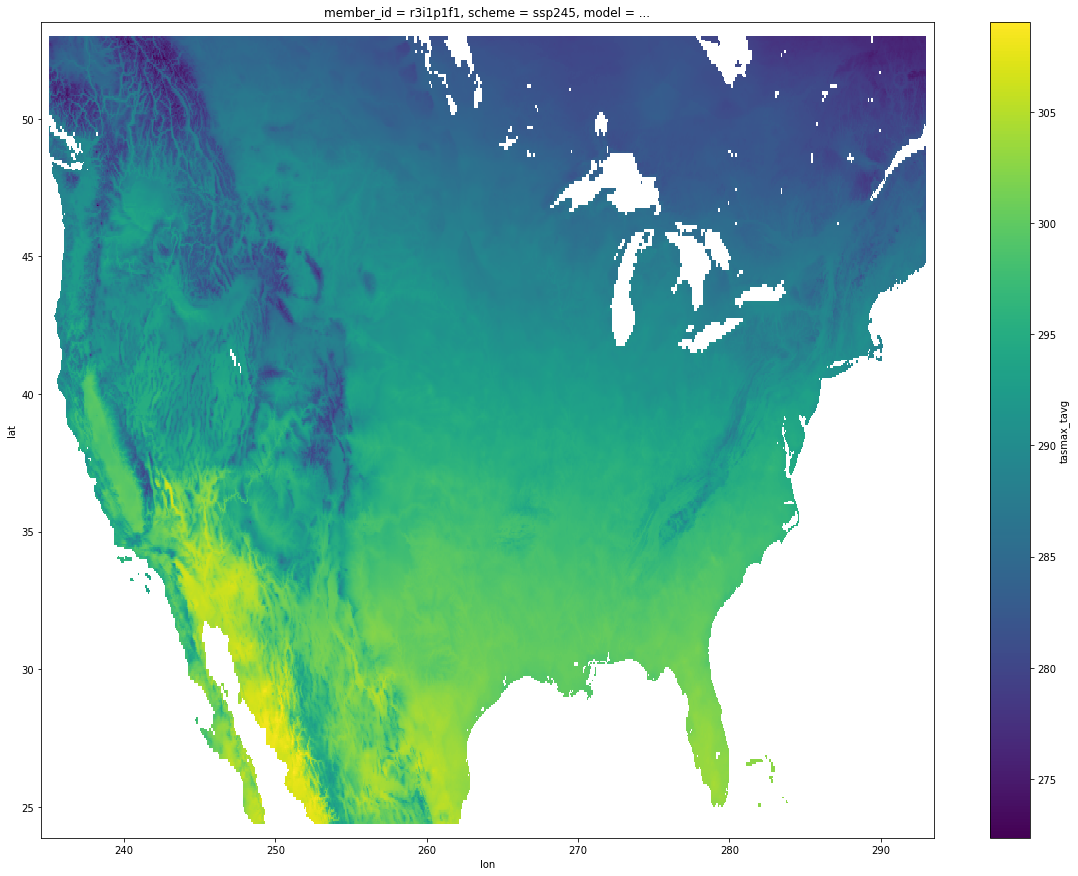

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.rcParams['figure.figsize'] = [20, 15]
#fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
#ax = ax.flatten()

dat_total.tasmax_tavg.sel(member_id='r3i1p1f1').sel(scheme='ssp245').sel(model='FGOALS-g3').mean('time').plot()


In [2]:
import os
import xarray as xr
import intake
from dotenv import load_dotenv
import numpy as np
import geopandas
import pandas as pd



class OpenLocaCat:
    def __init__(self):
        load_dotenv()

        url = "s3://ees240146/loca2_zarr_monthly_esm_catalog.json"
        catalog = intake.open_esm_datastore(url,
                                            storage_options={
                                            "anon": True,
                                            "endpoint_url": os.environ['S3_ENDPOINT_URL']
                                            })
        
        self.catalog = catalog
        print('Initialized')
        print(catalog)
    
    def load(self, query):
        catalog_subset = self.catalog.search(**query)
        
        dsets = catalog_subset.to_dataset_dict(
                                    xarray_open_kwargs={"use_cftime": True, "engine": 'zarr'},
                                    storage_options={"anon": True, "endpoint_url": os.environ['S3_ENDPOINT_URL']}
                                    )
        
        # Nested list to contain datasets. Nested by scheme, variable, model, and member ID
        dataset_list = [[[[[np.nan, np.nan, np.nan] for _ in catalog_subset.unique()['experiment_id']
                          ] for _ in catalog_subset.unique()['model']
                         ] for _ in catalog_subset.unique()['variable']
                        ] for _ in catalog_subset.unique()['scheme']]

        # Iterates through all datasets and labels them accordingly
        for dataset in dsets:
            dataset_contents = dsets[dataset]
            dataset_contents.coords['member_id'] = dsets[dataset].attrs['intake_esm_attrs:experiment_id']
            dataset_contents.coords['scheme'] = dsets[dataset].attrs['intake_esm_attrs:scheme']
            #dataset_contents.coords['variable'] = dsets[dataset].attrs['intake_esm_attrs:variable']
            dataset_contents.coords['model'] = dsets[dataset].attrs['intake_esm_attrs:model']

        # Estimates amount of time series needed for empty datasets (needed to fill gaps)
        sum_time = 0
        if 'historical' in catalog_subset.unique()['scheme']:
            sum_time += 780
        if any(map(lambda i: i in ['ssp245','ssp370','ssp585'], catalog_subset.unique()['scheme'])):
            sum_time += 1032



        scheme_index = 0
        for scheme in catalog_subset.unique()['scheme']: # Iterate over schemes
            list_scheme = []
            for dataset_key in dsets: # Iterates over all datasets chosen to find the ones to pull
                dataset = dsets[dataset_key]
                if dataset['scheme'] == scheme:
                    list_scheme.append(dataset)
            var_index = 0
            for variable in catalog_subset.unique()['variable']: # Iterate over variables
                list_var = []
                for dataset in list_scheme:
                    if dataset.attrs['intake_esm_attrs:variable'] == variable:
                        list_var.append(dataset)
                model_index = 0
                for model in catalog_subset.unique()['model']: # Iterate over models
                    list_model = []
                    for dataset in list_var:
                        if dataset['model'] == model:
                            list_model.append(dataset)
                    member_index = 0
                    for member_id in catalog_subset.unique()['experiment_id']: # Iterate over member IDs
                        list_id = []
                        for dataset in list_model: # Pick out all datasets along the time series
                            if dataset['member_id'] == member_id:
                                list_id.append(dataset)
                        # Sort dataset so it's in chronological order
                        list_id = sorted(list_id, key=lambda x:x.attrs['intake_esm_attrs:time_range']) 
                        if list_id: #If datasets exist
                            dataset_complete = xr.concat(list_id,'time', coords='minimal', compat='equals') # Concatenate
                            dataset_list[scheme_index][var_index][model_index][member_index] = dataset_complete 
                        else: # If no datasets for this set of parameters
                            # Create an empty dataset with the correct dimensions and labeled accordingly
                            empty_dataset = xr.DataArray(
                                                    np.full((sum_time,474,944),np.nan),
                                                    dims=['time','lat','lon']).to_dataset(name=variable + '_tavg')
                            print(empty_dataset)
                            empty_dataset.coords['member_id'] = member_id
                            empty_dataset.coords['scheme'] = scheme
                            empty_dataset.coords['model'] = model
                            print('Empty!') # Informs the user that there's an empty dataset present
                            dataset_list[scheme_index][var_index][model_index][member_index] = empty_dataset
                        member_index += 1
                    model_index += 1
                var_index += 1
            scheme_index += 1

        dataset_full = xr.combine_nested(dataset_list, concat_dim=['scheme',None,'model','member_id'], fill_value=np.nan, 
                                      compat='no_conflicts', data_vars='different')
        datetimeindex = dataset_full.indexes['time'].to_datetimeindex()
        dataset_full['time'] = datetimeindex
        
        return dataset_full
        
    def stats(self, dataset, coords):
        """
        Calculates statistics across the models for all variables
    
        Input:
            - dataset (Dataset or Dataarray) - Needs a dimension called "model"
        
        Output:
            - data_stats (Dataset) - Contains calculations of the mean, standard deviation, and variance
                of the dataset. All statistics stored in a coordinate called "stats"
            
        """

        dataset_mean = dataset
        dataset_stdev = dataset
        dataset_var = dataset


        for coord in coords:
            dataset_mean = dataset_mean.mean(coord)
            dataset_stdev = dataset_stdev.std(coord)
            dataset_var = dataset_var.var(coord)
            print(dataset_mean)
            
        dataset_mean['stats'] = 'mean'
        dataset_stdev['stats'] = 'stdev'
        dataset_var['stats'] = 'variance'
    
        data_stats = xr.concat([dataset_mean, dataset_stdev, dataset_var], 'stats')
        return data_stats
    
    def illinois(self, dataset):
        dataset_ill = dataset.sel(lat=slice(36,43.5)).sel(lon=slice(267.2,274))
        
        return dataset_ill

    def parquet(self, dataset, filename):
        
        dataframe = dataset.to_dataframe()
        dataframe_reset = dataframe.reset_index()
        gdf = geopandas.GeoDataFrame(
                dataframe_reset, 
                geometry=geopandas.points_from_xy(dataframe_reset.lon, dataframe_reset.lat), 
                crs="NAD83",
                )

        del gdf['lat']
        del gdf['lon']

        print(gdf)
        
        #gdf.to_parquet(filename)



In [3]:
OpenLocaCat = OpenLocaCat()

Initialized
<loca2_zarr_monthly_esm_catalog catalog with 2313 dataset(s) from 2313 asset(s)>


In [4]:
query = dict(variable=['tasmax','pr'],
             model=['ACCESS-CM2'],
             scheme=["ssp370"],
             experiment_id=['r1i1p1f1','r2i1p1f1'])

test_dataset = OpenLocaCat.load(query)
test_dataset


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.model.scheme.experiment_id.time_range.path'


/tmp/ipykernel_3339/2602692362.py:105: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  datetimeindex = dataset_full.indexes['time'].to_datetimeindex()


<xarray.Dataset> Size: 7GB
Dimensions:      (member_id: 2, model: 1, scheme: 1, time: 1032, lat: 474,
                  lon: 944)
Coordinates:
  * lat          (lat) float32 2kB 23.91 23.97 24.03 24.09 ... 53.34 53.41 53.47
  * lon          (lon) float32 4kB 234.5 234.6 234.7 234.7 ... 293.3 293.4 293.5
  * time         (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16...
  * member_id    (member_id) <U8 64B 'r2i1p1f1' 'r1i1p1f1'
  * scheme       (scheme) <U6 24B 'ssp370'
  * model        (model) <U10 40B 'ACCESS-CM2'
Data variables:
    tasmax_tavg  (member_id, model, scheme, time, lat, lon) float32 4GB dask.array<chunksize=(1, 1, 1, 45, 60, 236), meta=np.ndarray>
    pr_tavg      (member_id, model, scheme, time, lat, lon) float32 4GB dask.array<chunksize=(1, 1, 1, 45, 60, 236), meta=np.ndarray>

In [5]:
test_dataset_stats = OpenLocaCat.stats(test_dataset.sel(time=slice('2020-01-16','2025-01-16')),['time','member_id','model'])
test_dataset_stats

<xarray.Dataset> Size: 7MB
Dimensions:      (member_id: 2, model: 1, scheme: 1, lat: 474, lon: 944)
Coordinates:
  * lat          (lat) float32 2kB 23.91 23.97 24.03 24.09 ... 53.34 53.41 53.47
  * lon          (lon) float32 4kB 234.5 234.6 234.7 234.7 ... 293.3 293.4 293.5
  * member_id    (member_id) <U8 64B 'r2i1p1f1' 'r1i1p1f1'
  * scheme       (scheme) <U6 24B 'ssp370'
  * model        (model) <U10 40B 'ACCESS-CM2'
Data variables:
    tasmax_tavg  (member_id, model, scheme, lat, lon) float32 4MB dask.array<chunksize=(1, 1, 1, 60, 236), meta=np.ndarray>
    pr_tavg      (member_id, model, scheme, lat, lon) float32 4MB dask.array<chunksize=(1, 1, 1, 60, 236), meta=np.ndarray>
<xarray.Dataset> Size: 4MB
Dimensions:      (model: 1, scheme: 1, lat: 474, lon: 944)
Coordinates:
  * lat          (lat) float32 2kB 23.91 23.97 24.03 24.09 ... 53.34 53.41 53.47
  * lon          (lon) float32 4kB 234.5 234.6 234.7 234.7 ... 293.3 293.4 293.5
  * scheme       (scheme) <U6 24B 'ssp370'
  * mode

/data/keeling/a/mailes2/miniconda3/envs/geoparquet/lib/python3.12/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension stats because variable stats is not a coordinate. To create an index for stats, please first call `.set_coords('stats')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


<xarray.Dataset> Size: 11MB
Dimensions:      (stats: 3, scheme: 1, lat: 474, lon: 944)
Coordinates:
  * stats        (stats) <U8 96B 'mean' 'stdev' 'variance'
  * lat          (lat) float32 2kB 23.91 23.97 24.03 24.09 ... 53.34 53.41 53.47
  * lon          (lon) float32 4kB 234.5 234.6 234.7 234.7 ... 293.3 293.4 293.5
  * scheme       (scheme) <U6 24B 'ssp370'
Data variables:
    tasmax_tavg  (stats, scheme, lat, lon) float32 5MB dask.array<chunksize=(1, 1, 60, 236), meta=np.ndarray>
    pr_tavg      (stats, scheme, lat, lon) float32 5MB dask.array<chunksize=(1, 1, 60, 236), meta=np.ndarray>

In [6]:
OpenLocaCat.parquet(test_dataset_stats, '')

/data/keeling/a/mailes2/miniconda3/envs/geoparquet/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


            stats  scheme  tasmax_tavg  pr_tavg                    geometry
0            mean  ssp370          NaN      NaN  POINT (234.53125 23.90625)
1            mean  ssp370          NaN      NaN  POINT (234.59375 23.90625)
2            mean  ssp370          NaN      NaN  POINT (234.65625 23.90625)
3            mean  ssp370          NaN      NaN  POINT (234.71875 23.90625)
4            mean  ssp370          NaN      NaN  POINT (234.78125 23.90625)
...           ...     ...          ...      ...                         ...
1342363  variance  ssp370          NaN      NaN  POINT (293.21875 53.46875)
1342364  variance  ssp370          NaN      NaN  POINT (293.28125 53.46875)
1342365  variance  ssp370          NaN      NaN  POINT (293.34375 53.46875)
1342366  variance  ssp370          NaN      NaN  POINT (293.40625 53.46875)
1342367  variance  ssp370          NaN      NaN  POINT (293.46875 53.46875)

[1342368 rows x 5 columns]


In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

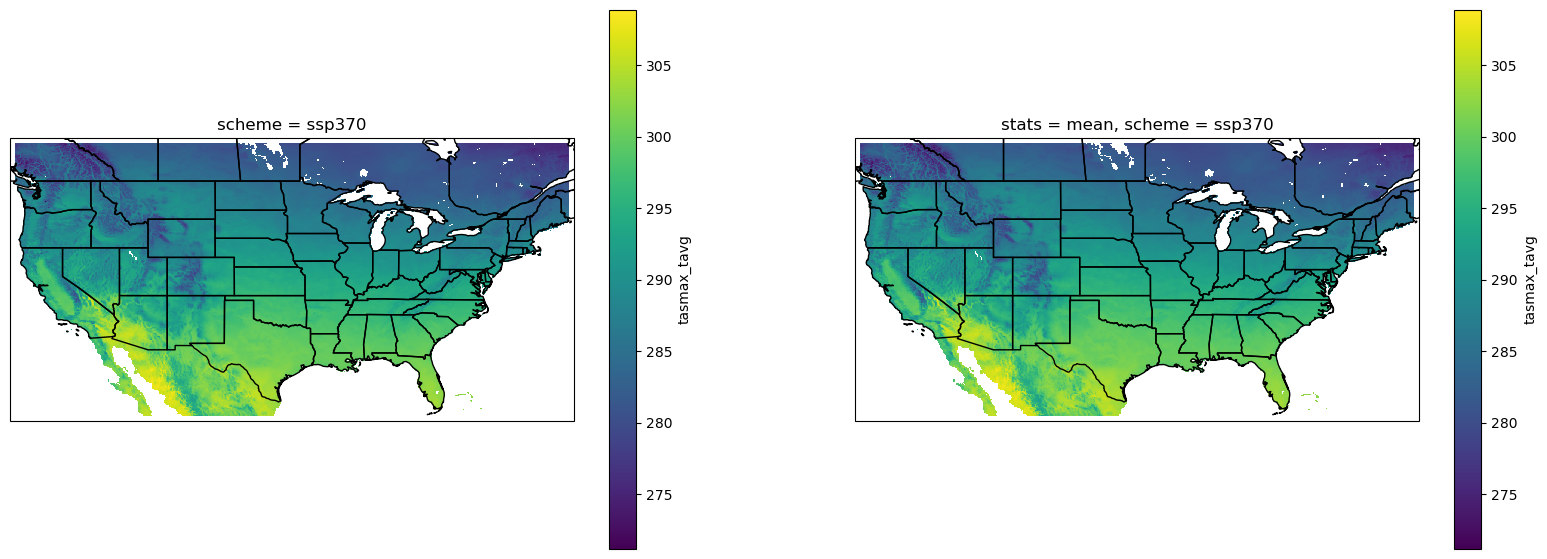

In [7]:
plt.rcParams['figure.figsize'] = [20,7]
fig, [ax1,ax2] = plt.subplots(1,2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

test_dataset.tasmax_tavg.sel(time=slice('2020-01-16','2025-01-16')).mean('time').mean('member_id').mean('model').plot(ax=ax1, 
                                                                                                                      transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.STATES)

test_dataset_stats.tasmax_tavg.sel(stats='mean').plot(ax=ax2, transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.STATES)

In [11]:
#test_dataset_crop = test_dataset.sel(time=slice('2020-01-16','2030-01-16'))
test_dataset_ill = OpenLocaCat.illinois(test_dataset)
print(test_dataset_ill)
test_gdf = OpenLocaCat.parquet(test_dataset_ill, '')

<xarray.Dataset> Size: 216MB
Dimensions:      (member_id: 2, model: 1, scheme: 1, time: 1032, lat: 120,
                  lon: 109)
Coordinates:
  * lat          (lat) float32 480B 36.03 36.09 36.16 ... 43.34 43.41 43.47
  * lon          (lon) float32 436B 267.2 267.3 267.3 ... 273.8 273.9 274.0
  * time         (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16...
  * member_id    (member_id) <U8 64B 'r2i1p1f1' 'r1i1p1f1'
  * scheme       (scheme) <U6 24B 'ssp370'
  * model        (model) <U10 40B 'ACCESS-CM2'
Data variables:
    tasmax_tavg  (member_id, model, scheme, time, lat, lon) float32 108MB dask.array<chunksize=(1, 1, 1, 45, 46, 109), meta=np.ndarray>
    pr_tavg      (member_id, model, scheme, time, lat, lon) float32 108MB dask.array<chunksize=(1, 1, 1, 45, 46, 109), meta=np.ndarray>
         member_id       model  scheme                time  tasmax_tavg  \
0         r2i1p1f1  ACCESS-CM2  ssp370 2015-01-16 12:00:00   283.233398   
1         r2i1p1f1  ACCESS-CM2  ssp

In [15]:
test_gdf.loc[test_gdf['member_id']=='r1i1p1f1']

,member_id,model,scheme,time,lat,lon,tasmax_tavg,geometry
108284352,r1i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.53125,NaN,POINT (234.53125 23.90625)
108284353,r1i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.59375,NaN,POINT (234.59375 23.90625)
108284354,r1i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.65625,NaN,POINT (234.65625 23.90625)
108284355,r1i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.71875,NaN,POINT (234.71875 23.90625)
108284356,r1i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.78125,NaN,POINT (234.78125 23.90625)
...,...,...,...,...,...,...,...,...
162426523,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,53.46875,293.21875,NaN,POINT (293.21875 53.46875)
162426524,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,53.46875,293.28125,NaN,POINT (293.28125 53.46875)
162426525,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,53.46875,293.34375,NaN,POINT (293.34375 53.46875)
162426526,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,53.46875,293.40625,NaN,POINT (293.40625 53.46875)


In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

In [35]:
test_gdf['tasmax_tavg'][0]

np.float32(nan)

In [42]:
test_gdf.loc[test_gdf['tasmax_tavg'].notnull()]

,member_id,model,scheme,time,lat,lon,tasmax_tavg,geometry
7776,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,24.40625,248.53125,300.744324,POINT (248.53125 24.40625)
7777,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,24.40625,248.59375,300.826843,POINT (248.59375 24.40625)
7778,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,24.40625,248.65625,300.930878,POINT (248.65625 24.40625)
7779,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,24.40625,248.71875,301.065125,POINT (248.71875 24.40625)
7780,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,24.40625,248.78125,301.414429,POINT (248.78125 24.40625)
...,...,...,...,...,...,...,...,...
162418963,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,52.96875,292.71875,261.421967,POINT (292.71875 52.96875)
162418964,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,52.96875,292.78125,261.502777,POINT (292.78125 52.96875)
162418965,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,52.96875,292.84375,261.444885,POINT (292.84375 52.96875)
162418966,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,52.96875,292.90625,261.623474,POINT (292.90625 52.96875)


In [45]:
test_gdf.loc[(test_gdf['member_id']=='r2i1p1f1') 
& (test_gdf['time']==cftime.DatetimeGregorian(2025, 8, 16, 12, 0, 0, 0, has_year_zero=False)) 
& (test_gdf['lat']>40) & (test_gdf['lat']<43) & (test_gdf['lon']>293) & (test_gdf['lon']<295)]#.loc[test_gdf['time']=='2030-01-16 12:00:00']

,member_id,model,scheme,time,lat,lon,tasmax_tavg,geometry
30224040,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,40.03125,293.03125,NaN,POINT (293.03125 40.03125)
30224041,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,40.03125,293.09375,NaN,POINT (293.09375 40.03125)
30224042,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,40.03125,293.15625,NaN,POINT (293.15625 40.03125)
30224043,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,40.03125,293.21875,NaN,POINT (293.21875 40.03125)
30224044,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,40.03125,293.28125,NaN,POINT (293.28125 40.03125)
...,...,...,...,...,...,...,...,...
30268411,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,42.96875,293.21875,NaN,POINT (293.21875 42.96875)
30268412,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,42.96875,293.28125,NaN,POINT (293.28125 42.96875)
30268413,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,42.96875,293.34375,NaN,POINT (293.34375 42.96875)
30268414,r2i1p1f1,ACCESS-CM2,ssp370,2025-08-16 12:00:00,42.96875,293.40625,NaN,POINT (293.40625 42.96875)


In [30]:
test_gdf.loc[(test_gdf['lat']<36.03) & (test_gdf['lon']<2]

,member_id,model,scheme,time,lat,lon,tasmax_tavg,geometry
0,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.53125,NaN,POINT (234.53125 23.90625)
1,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.59375,NaN,POINT (234.59375 23.90625)
2,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.65625,NaN,POINT (234.65625 23.90625)
3,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.71875,NaN,POINT (234.71875 23.90625)
4,r2i1p1f1,ACCESS-CM2,ssp370,2020-01-16 12:00:00,23.90625,234.78125,NaN,POINT (234.78125 23.90625)
...,...,...,...,...,...,...,...,...
162162203,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,35.96875,293.21875,NaN,POINT (293.21875 35.96875)
162162204,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,35.96875,293.28125,NaN,POINT (293.28125 35.96875)
162162205,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,35.96875,293.34375,NaN,POINT (293.34375 35.96875)
162162206,r1i1p1f1,ACCESS-CM2,ssp370,2030-01-16 12:00:00,35.96875,293.40625,NaN,POINT (293.40625 35.96875)


<GeoAxes: >

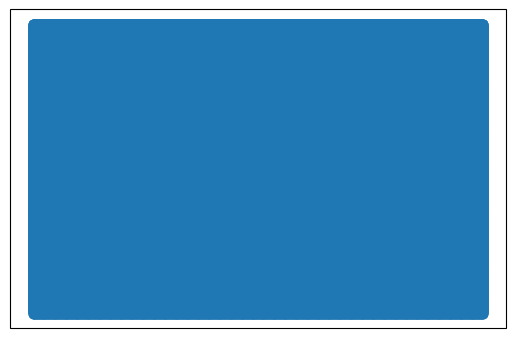

In [43]:
ax = plt.axes(projection=ccrs.PlateCarree())
test_gdf.loc[(test_gdf['member_id']=='r1i1p1f1') 
& (test_gdf['time']==cftime.DatetimeGregorian(2025, 8, 16, 12, 0, 0, 0, has_year_zero=False))].plot(ax=ax, transform=ccrs.PlateCarree())

In [3]:
test_dataset_IL = OpenLocaCat.illinois(test_dataset)
test_dataset_IL

<xarray.Dataset> Size: 3GB
Dimensions:      (member_id: 3, model: 2, scheme: 3, time: 1812, lat: 120,
                  lon: 109)
Coordinates:
  * lat          (lat) float32 480B 36.03 36.09 36.16 ... 43.34 43.41 43.47
  * lon          (lon) float32 436B 267.2 267.3 267.3 ... 273.8 273.9 274.0
  * time         (time) object 14kB 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id    (member_id) <U8 96B 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * scheme       (scheme) <U10 120B 'ssp245' 'ssp370' 'historical'
  * model        (model) <U10 80B 'ACCESS-CM2' 'TaiESM1'
Data variables:
    tasmax_tavg  (member_id, model, scheme, time, lat, lon) float64 3GB dask.array<chunksize=(1, 1, 1, 43, 46, 8), meta=np.ndarray>

In [5]:
test_dataset_stats = OpenLocaCat.stats(test_dataset)
test_dataset_stats

/data/keeling/a/mailes2/miniconda3/envs/geoparquet/lib/python3.12/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension stats because variable stats is not a coordinate. To create an index for stats, please first call `.set_coords('stats')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


<xarray.Dataset> Size: 175GB
Dimensions:      (stats: 3, member_id: 3, scheme: 3, time: 1812, lat: 474,
                  lon: 944)
Coordinates:
  * stats        (stats) <U8 96B 'mean' 'stdev' 'variance'
  * lat          (lat) float32 2kB 23.91 23.97 24.03 24.09 ... 53.34 53.41 53.47
  * lon          (lon) float32 4kB 234.5 234.6 234.7 234.7 ... 293.3 293.4 293.5
  * time         (time) object 14kB 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id    (member_id) <U8 96B 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * scheme       (scheme) <U10 120B 'ssp245' 'ssp370' 'historical'
Data variables:
    tasmax_tavg  (stats, member_id, scheme, time, lat, lon) float64 175GB dask.array<chunksize=(1, 1, 1, 43, 60, 118), meta=np.ndarray>

In [37]:
test_dataset.tasmax_tavg.sel(member_id='r3i1p1f1').sel(scheme='ssp245').sel(
                                        model='ACCESS-CM2').sel(time='2065-08-16').values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

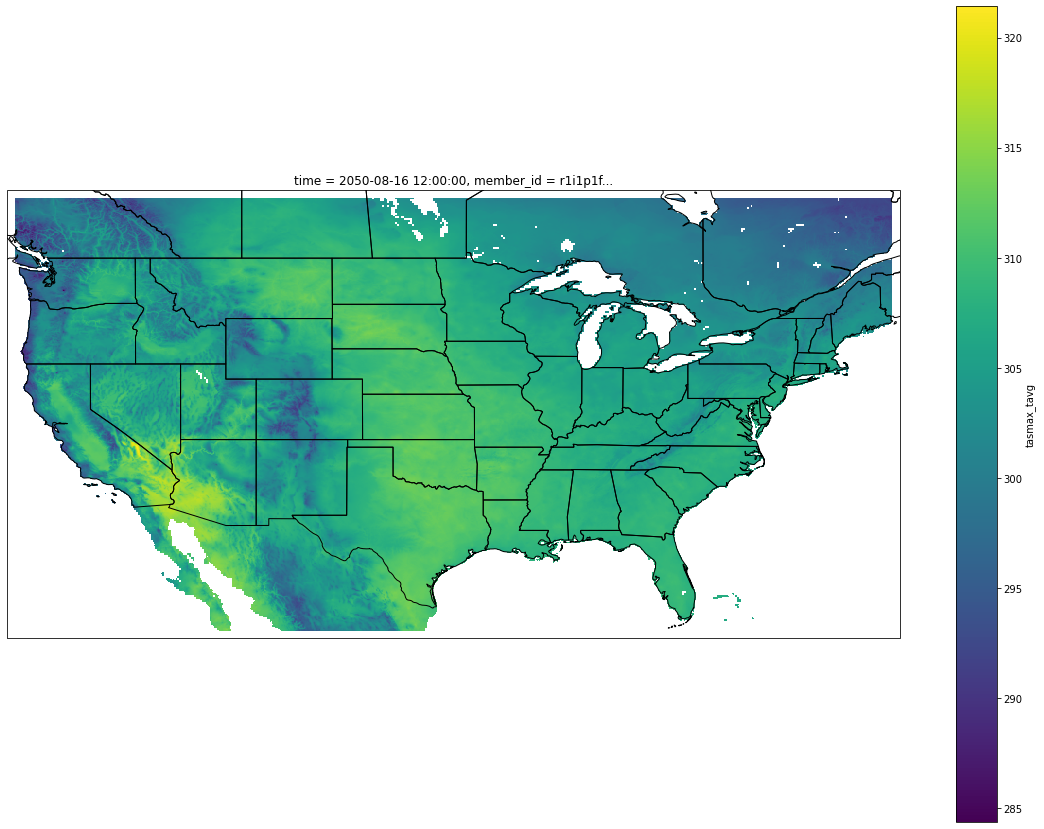

In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams['figure.figsize'] = [20, 15]
#fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
#ax = ax.flatten()
ax = plt.axes(projection=ccrs.PlateCarree())


test_dataset.tasmax_tavg.sel(member_id='r1i1p1f1').sel(scheme='ssp245').sel(
                                        model='ACCESS-CM2').sel(time='2050-08-16').plot()
ax.add_feature(cfeature.STATES)

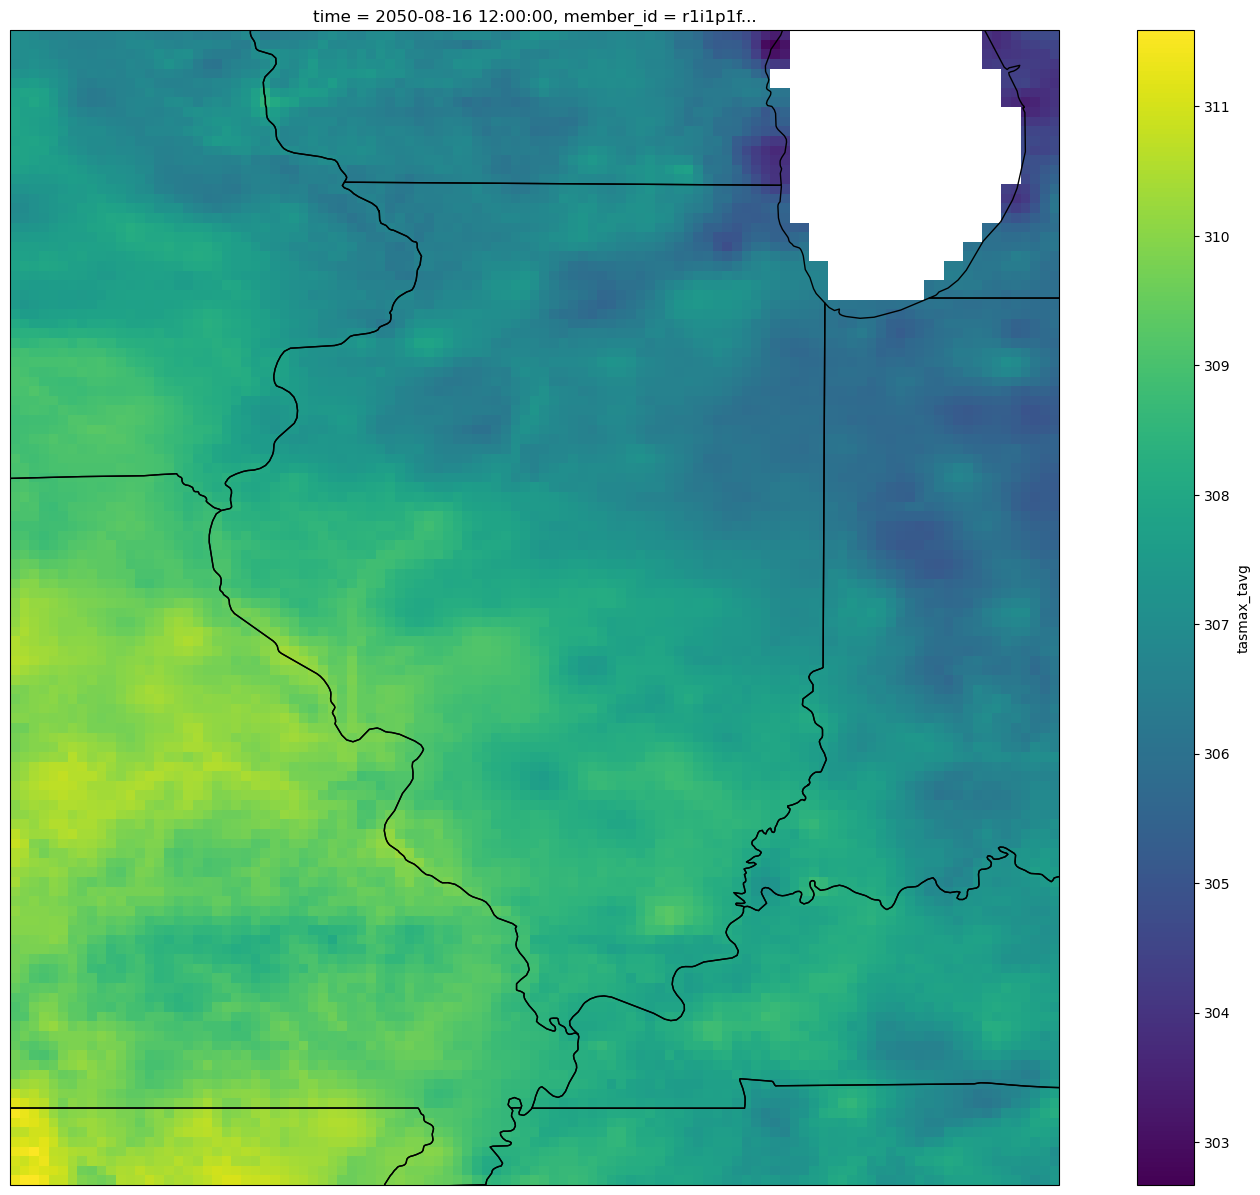

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams['figure.figsize'] = [20, 15]
#fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
#ax = ax.flatten()
ax = plt.axes(projection=ccrs.PlateCarree())


test_dataset_IL.tasmax_tavg.sel(member_id='r1i1p1f1').sel(scheme='ssp245').sel(
                                        model='ACCESS-CM2').sel(time='2050-08-16').plot()
ax.add_feature(cfeature.STATES)